C:\ProgramData\Anaconda4\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


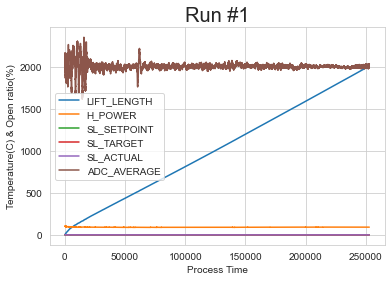

In [66]:
import pandas as pd
import numpy as np
from pandas import read_csv
from datetime import datetime
from pandas import DataFrame
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model 
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import pickle

from pandas import set_option

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.neighbors import LocalOutlierFactor 

# Import CSV data file

df = pd.read_csv('Body.csv')
df1 = df.drop(['time'],axis=1)
plt.plot(df1, label=df1.columns)
plt.title("Run #1",fontsize=20)
plt.xlabel("Process Time",fontsize=10)
plt.ylabel("Temperature(C) & Open ratio(%)",fontsize=10)
plt.legend()

In [67]:
df1 = df1.drop(['H_POWER','SL_SETPOINT','SL_TARGET'],axis=1)
df1 = df1[:100000]

In [68]:
# n_in, n_out에 따라 가져올 시점의 데이터가 달라짐. 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
  # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
  # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [69]:
reframed1 = series_to_supervised(df1, 3, 1)
reframed1

,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
3,0.0,2.282,1983.0,0.0,2.282,1985.0,0.0,2.282,1986.0,0,2.282,1979
4,0.0,2.282,1985.0,0.0,2.282,1986.0,0.0,2.282,1979.0,0,2.303,1977
5,0.0,2.282,1986.0,0.0,2.282,1979.0,0.0,2.303,1977.0,0,2.303,1974
6,0.0,2.282,1979.0,0.0,2.303,1977.0,0.0,2.303,1974.0,0,2.303,1969
7,0.0,2.303,1977.0,0.0,2.303,1974.0,0.0,2.303,1969.0,0,2.324,1966
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,812.0,0.418,2024.0,812.0,0.418,2024.0,812.0,0.439,2024.0,812,0.439,2024
99996,812.0,0.418,2024.0,812.0,0.439,2024.0,812.0,0.439,2024.0,812,0.439,2023
99997,812.0,0.439,2024.0,812.0,0.439,2024.0,812.0,0.439,2023.0,812,0.418,2023
99998,812.0,0.439,2024.0,812.0,0.439,2023.0,812.0,0.418,2023.0,812,0.418,2023


In [70]:
X = reframed1.drop(['var1(t)','var2(t)','var3(t)'], axis=1)
y = reframed1['var3(t)']

In [96]:
# Machine Learning Model comparision

import sklearn.metrics as sm
from sklearn.cross_decomposition import PLSRegression
import sklearn.gaussian_process as gp
import xgboost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=7)

models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
#models.append(('Gaussian', Pipeline([('Scaler', StandardScaler()),('Gaussian',gp())])))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('AB', AdaBoostRegressor()))
models.append(('GBM', GradientBoostingRegressor(n_estimators=75)))
models.append(('xgboost', xgboost.XGBRegressor(n_estimators= 100)))
models.append(('RF',RandomForestRegressor()))
models.append(('ET', ExtraTreesRegressor()))

results = []
names = []

msg = []
mean = []
std = []

Title = []
MAE = []
MSE = []
R2 = []

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
    
for name, model in models:
#    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
#    cv_results = cross_val_score(model, rescaledX, y_train, cv=kfold, scoring='r2')
#    results.append(abs(cv_results))
#    names.append(name)
#    msg.append('%s' % (name))
#    mean.append('%f' %  (abs(cv_results.mean())))
#    std.append('%f' % (cv_results.std()))

    
    
    model = model
    model.fit(rescaledX, y_train)
        
    rescaledTestX = scaler.transform(X_test)
    predictions = model.predict(rescaledTestX)
    predictions2 = model.predict(rescaledX)
    
    y_test = np.array(y_test)
    
    y_test = pd.DataFrame(y_test)
    predictions = pd.DataFrame(predictions)
    
    
    Title.append('%s' % name)
    MAE.append('%f' %  round(sm.mean_absolute_error(y_test, predictions),5))
    
    
    MSE.append('%f' %  round(sm.mean_squared_error(y_test, predictions),5))
    R2.append('%f' %  round(sm.r2_score(y_test,predictions),5))

    
#Final_result = pd.DataFrame(np.transpose(msg))
#Final_result.columns = ['Model']
#Final_result['Mean'] = pd.DataFrame(np.transpose(mean))
#Final_result['Std'] = pd.DataFrame(np.transpose(std))

F2_result = pd.DataFrame(Title)
F2_result.columns = ['Model']
#F2_result['MAE'] = pd.DataFrame(MAE)
F2_result['MSE'] = pd.DataFrame(MSE)
F2_result['R2'] = pd.DataFrame(R2)
#F_result['Std'] = pd.DataFrame(round(sm.r2_score(y_test,predictions),5))

F2_result

C:\ProgramData\Anaconda4\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda4\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda4\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_15944/1176900244.py:50: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel(

,Model,MSE,R2
0,LR,0.310580,0.998870
1,LASSO,1.403180,0.994910
2,KNN,0.974330,0.996460
3,CART,0.559300,0.997970
4,SVR,0.526930,0.998090
5,AB,2.052820,0.992550
6,GBM,0.389230,0.998590
7,xgboost,0.307590,0.998880
8,RF,0.362680,0.998680
9,ET,0.424020,0.998460


In [106]:
# Final Optimum Model

import sklearn.metrics as sm
from sklearn.cross_decomposition import PLSRegression
import sklearn.gaussian_process as gp
import xgboost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=7)

models = []
models.append(('LR', LinearRegression()))

results = []
names = []

msg = []
mean = []
std = []

Title = []
MAE = []
MSE = []
R2 = []

# MAE, MSE, R2 value
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

for name, model in models:
#    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
#    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
#    results.append(abs(cv_results))
#    names.append(name)
#    msg.append('%s' % (name))
#    mean.append('%f' %  (abs(cv_results.mean())))
#    std.append('%f' % (cv_results.std()))

    
    model = model
    model.fit(rescaledX, y_train)
        
    rescaledTestX = scaler.transform(X_test)
    predictions = model.predict(rescaledTestX)
    predictions2 = model.predict(rescaledX)
    
    y_test = np.array(y_test)
    
    y_test = pd.DataFrame(y_test)
    predictions = pd.DataFrame(predictions)
    
    
    Title.append('%s' % name)
    MAE.append('%f' %  round(sm.mean_absolute_error(y_test, predictions),5))
   
    MSE.append('%f' %  round(sm.mean_squared_error(y_test, predictions),5))
    R2.append('%f' %  round(sm.r2_score(y_test,predictions),5))

    
#Final_result = pd.DataFrame(np.transpose(msg))
#Final_result.columns = ['Model']
#Final_result['Mean'] = pd.DataFrame(np.transpose(mean))
#Final_result['Std'] = pd.DataFrame(np.transpose(std))

F2_result = pd.DataFrame(Title)
F2_result.columns = ['Model']
#F2_result['MAE'] = pd.DataFrame(MAE)
F2_result['MSE'] = pd.DataFrame(MSE)
F2_result['R2'] = pd.DataFrame(R2)
#F_result['Std'] = pd.DataFrame(round(sm.r2_score(y_test,predictions),5))

F2_result

,Model,MSE,R2
0,LR,0.310580,0.998870


In [107]:
model.coef_

array([[ 3.21076682e+00, -8.54841988e-02, -6.03507484e+00,
        -1.86822174e+01,  2.56437238e-02,  2.94225263e+00,
         1.54798505e+01,  8.64823316e-03,  1.97351391e+01]])

In [108]:
model.intercept_

array([2004.98394945])

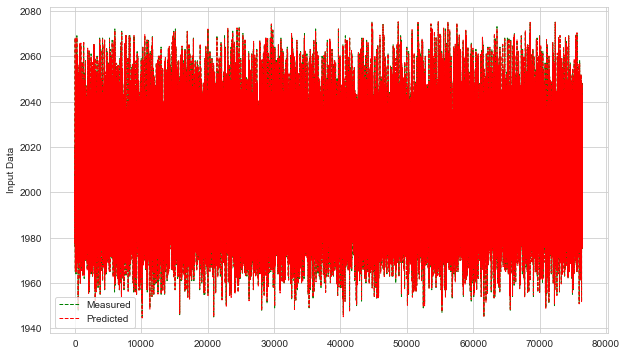

In [109]:
plt.figure(figsize=(10, 6))
#plt.subplot(2,1,1)
t = []
t = range(1,X_test.shape[0])

plt.plot(y_test,'g--',linewidth=1,label='Process Data')
plt.plot(predictions,'r--',linewidth=1,label='Initial Guess')
#plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.ylabel('Output')
plt.legend(loc='best')
#plt.subplot(2,1,2)
#plt.plot(t,u,'bx-',linewidth=2)
#plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Predicted'],loc='best')
plt.ylabel('Input Data')
plt.show()

In [121]:
df2 = df[252000:]
df2 = df2.drop(['time','H_POWER','SL_TARGET','SL_SETPOINT'],axis=1)
df2

,LIFT_LENGTH,SL_ACTUAL,ADC_AVERAGE
252000,2002,0.418,1985
252001,2002,0.418,1986
252002,2002,0.418,1986
252003,2002,0.460,1987
252004,2002,0.460,1987
...,...,...,...
252891,2009,0.586,2037
252892,2009,0.586,2037
252893,2009,0.586,2037
252894,2009,0.586,2037


In [122]:
reframed2 = series_to_supervised(df2, 3, 1)
reframed2 = reframed2.reset_index()
reframed2 = reframed2.drop(['index'],axis=1) 
reframed2

,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
0,2002.0,0.418,1985.0,2002.0,0.418,1986.0,2002.0,0.418,1986.0,2002,0.460,1987
1,2002.0,0.418,1986.0,2002.0,0.418,1986.0,2002.0,0.460,1987.0,2002,0.460,1987
2,2002.0,0.418,1986.0,2002.0,0.460,1987.0,2002.0,0.460,1987.0,2002,0.460,1989
3,2002.0,0.460,1987.0,2002.0,0.460,1987.0,2002.0,0.460,1989.0,2002,0.439,1989
4,2002.0,0.460,1987.0,2002.0,0.460,1989.0,2002.0,0.439,1989.0,2002,0.439,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
888,2009.0,0.586,2037.0,2009.0,0.586,2037.0,2009.0,0.586,2037.0,2009,0.586,2037
889,2009.0,0.586,2037.0,2009.0,0.586,2037.0,2009.0,0.586,2037.0,2009,0.586,2037
890,2009.0,0.586,2037.0,2009.0,0.586,2037.0,2009.0,0.586,2037.0,2009,0.586,2037
891,2009.0,0.586,2037.0,2009.0,0.586,2037.0,2009.0,0.586,2037.0,2009,0.586,2037


In [123]:
X = reframed2.drop(['var1(t)','var2(t)','var3(t)'], axis=1)
y = reframed2['var3(t)']

In [124]:

R2 =[] 
rescaledX = scaler.transform(X)

predictions = model.predict(rescaledX)

y = pd.DataFrame(y)
predictions = pd.DataFrame(predictions)


Title.append('%s' % name)
MAE.append('%f' %  round(sm.mean_absolute_error(y, predictions),5))

MSE.append('%f' %  round(sm.mean_squared_error(y, predictions),5))
R2.append('%f' %  round(sm.r2_score(y,predictions),5))
R2

['0.997900']

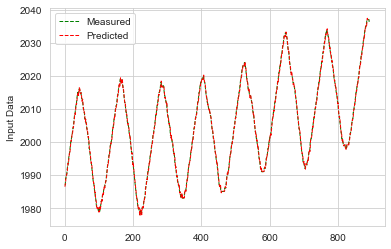

In [125]:
plt.plot(y,'g--',linewidth=1,label='Process Data')
plt.plot(predictions,'r--',linewidth=1,label='Initial Guess')

plt.ylabel('Output')
plt.legend(loc='best')

plt.legend(['Measured','Predicted'],loc='best')
plt.ylabel('Input Data')
plt.show()

# Temperature Identification model

In [ ]:
# FOPDT model find optimum parameter Km, Taum, Thetam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Import CSV data file

data = pd.read_csv('Body.csv')
#print(data)
t = data['time'].values - data['time'].values[0]
u = data['SL_ACTUAL'].values
yp = data['ADC_AVERAGE'].values
u0 = u[0]
yp0 = yp[0]

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)


# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = u0
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt


# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns)  # model
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1] = y1[-1]
    return ym


# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    
    # return result
    return obj


# initial guesses
x0 = np.zeros(3)
x0[0] = 2.0 # Km
x0[1] = 3.0 # taum
x0[2] = 0.0 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km, taum, thetam
solution = minimize(objective,x0, method ='Powell')

# Another way to solve: with bounds on variables
#bnds = ((0.4, 0.6), (1.0, 10.0), (0.0, 30.0))
#solution = minimize(objective,x0,bounds=bnds,method='SLSQP')
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

# calculate model with updated parameters
ym1 = sim_model(x0)
ym2 = sim_model(x)
# plot results
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()

Initial SSE Objective: 800803747.9526454


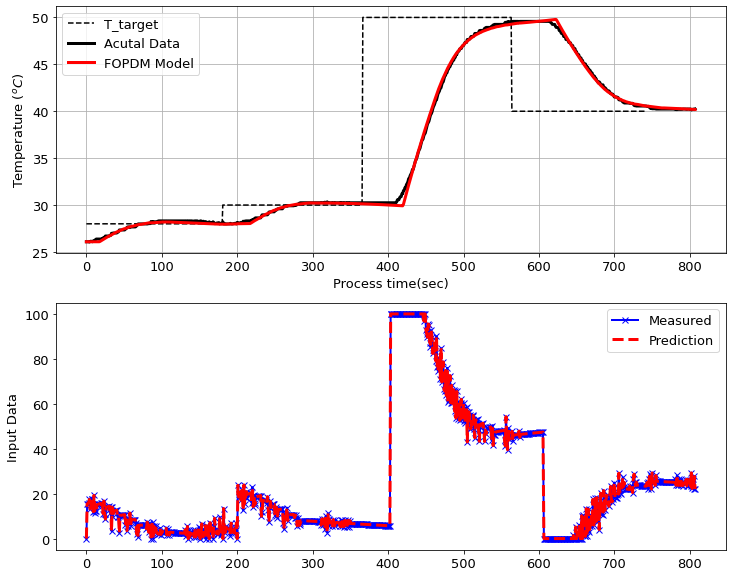

In [100]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(12, 10))
ax=plt.subplot(2,1,1)
ax.grid()
plt.plot(data['time'],data['Tsp'],'k--',label=r'T_target')
plt.plot(t,yp,'k',linewidth=3,label='Acutal Data')
plt.plot(t,ym2,'r',linewidth=3,label='FOPDM Model')
plt.xlabel('Process time(sec)')
plt.ylabel(r'Temperature ($^oC$)')
plt.legend(loc='best')


plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Prediction'],loc='best')
plt.ylabel('Input Data')
plt.show()

In [101]:
from numpy import linalg as LA

fitnessFD = 100*(1-(LA.norm((yp-ym2),ord=2))/(LA.norm((yp-yp.mean()),ord=2)))
fitnessFD

97.31024543469475

p3 v1
p3 v1
 ----------------------------------------------------------------
 APMonitor, Version 1.0.0
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  1
   Variables    :  10
   Intermediates:  1
   Connections  :  0
   Equations    :  2
   Residuals    :  1
 
 Number of state variables:    3194
 Number of total equations: -  3192
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    2
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License 

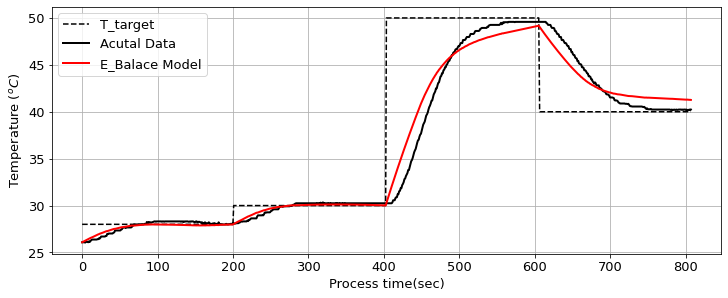

No handles with labels found to put in legend.


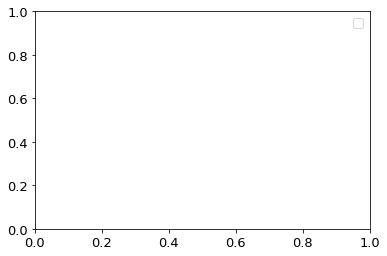

In [102]:
# Energy Balance Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gekko import GEKKO

# read data
url = 'validatePID02.txt'
data = pd.read_csv(url)
#print(data)
t = data['time'].values - data['time'].values[0]
u = data['u'].values
yp = data['y'].values
u0 = u[0]
yp0 = yp[0]



# Parameters

  
# Create GEKKO Model
m = GEKKO(remote=False)
m.time = data['time'].values

# Parameters to Estimate
U = m.FV(value=10,lb=1,ub=20)
alpha1 = m.FV(value=0.01,lb=0.003,ub=0.03)  # W / % heater

# STATUS=1 allows solver to adjust parameter
U.STATUS = 1  
alpha1.STATUS = 1

# Measured inputs
Q1 = m.MV(value=data['u'].values)

# State variables
TC1 = m.CV(value=data['y'].values)
TC1.FSTATUS = 1    # minimize fstatus * (meas-pred)^2

print(Q1,TC1)

Ta = m.Param(value=26.0+273.15)     # K
mass = m.Param(value=4.0/1000.0)    # kg
Cp = m.Param(value=0.5*1000.0)      # J/kg-K    
A = m.Param(value=10.0/100.0**2)    # Area not between heaters in m^2
As = m.Param(value=2.0/100.0**2)    # Area between heaters in m^2
eps = m.Param(value=0.9)            # Emissivity
sigma = m.Const(5.67e-8)            # Stefan-Boltzmann

# Heater temperatures in Kelvin
T1 = m.Intermediate(TC1+273.15)


# Semi-fundamental correlations (energy balances)
m.Equation(TC1.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T1) \
                    + eps * sigma * A * (Ta**4 - T1**4) \
                    + alpha1*Q1))

print(Q1,TC1)
# Options
m.options.IMODE   = 5 # MHE
m.options.EV_TYPE = 2 # Objective type
m.options.NODES   = 2 # Collocation nodes
m.options.SOLVER  = 3 # IPOPT

# Solve
m.solve(disp=True)

# Parameter values
print('U     : ' + str(U.value[0]))
print('alpha1: ' + str(alpha1.value[0]))

plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(12, 10))
ax=plt.subplot(2,1,1)
ax.grid()
plt.plot(data['time'],data['Tsp'],'k--',label=r'T_target')
plt.plot(data['time'],yp,'k',linewidth=2,label='Acutal Data')
plt.plot(data['time'],TC1.value,'r',linewidth=2,label='E_Balace Model')
plt.xlabel('Process time(sec)')
plt.ylabel(r'Temperature ($^oC$)')
plt.legend(loc='best')
plt.show()

# plot results
#plt.figure(figsize=(12, 10))
#plt.subplot(2,1,1)
#plt.plot(t,yp,'kx-',linewidth=2,label='Acutal Data')
#plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
#plt.plot(t,ym2,'r--',linewidth=3,label='FOPDT model')
#plt.plot(m.time,np.array(T.value)-273.15,'r--',linewidth=3,label='Energy Balance Model')
#plt.ylabel('Output Temperature(℃)')
#plt.xlabel('Process time(sec)')
plt.legend(loc='best')
plt.show()

In [103]:
from numpy import linalg as LA


fitnessEB = 100*(1-(LA.norm((yp-TC1.value),ord=2))/(LA.norm((yp-yp.mean()),ord=2)))
fitnessEB

87.01113516328034

In [3]:
# prediction model

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display

n = 801 # time points to plot
tf = 800.0 # final time

# TCLab FOPDT
Kp = 0.5330669026753061
taup = 162.3364202585122
thetap = 16.921316269660974

def process(y,t,u):
    dydt = (1.0/taup) * (-(y-23.0) + Kp * u)
    return dydt



def pidPlot(Kc,tauI,tauD):
    t = np.linspace(0,tf,n) # create time vector
    P = np.zeros(n)          # initialize proportional term
    I = np.zeros(n)         # initialize integral term
    D = np.zeros(n)         # initialize derivative term
    e = np.zeros(n)         # initialize error
    OP = np.zeros(n)        # initialize controller output
    PV = np.ones(n)*23.0    # initialize process variable
    SP = np.ones(n)*23.0    # initialize setpoint
    SP[10:200] = 30.0       # step up
    SP[200:500] = 50.0      # step down    
    SP[500:801] = 40.0       # step up
    #SP[800:1201] = 40.0      # step down    
    y0 = 23.0               # initial condition
    iae = 0.0
    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        
        y = odeint(process,y0,ts,args=(OP[max(0,i-int(thetap))],))
        #print(y)

        y0 = y[1]                  # record new initial condition
        iae += np.abs(SP[i]-y0[0])
        #iae += np.abs(SP[i]-y0)
        # calculate new OP with PID
        PV[i] = y[1]               # record PV
        #PV[i] = y0               # record PV
        e[i] = SP[i] - PV[i]       # calculate error = SP - PV
        dt = t[i] - t[i-1]         # calculate time step
        P[i] = Kc * e[i]           # calculate proportional term
        I[i] = I[i-1] + (Kc/tauI) * e[i] * dt  # calculate integral term
        D[i] = -Kc * tauD * (PV[i]-PV[i-1])/dt # calculate derivative term
        OP[i] = P[i] + I[i] + D[i] # calculate new controller output
        if OP[i]>=100:
            OP[i] = 100.0
            I[i] = I[i-1] # reset integral
        if OP[i]<=0:
            OP[i] = 0.0
            I[i] = I[i-1] # reset integral            

    # plot PID response
    plt.figure(1,figsize=(15,7))
    plt.subplot(2,2,1)
    plt.plot(t,SP,'k-',linewidth=2,label='Setpoint (SP)')
    plt.plot(t,PV,'r:',linewidth=2,label='Temperature (PV)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(10,52,'Integral Abs Error: ' + str(np.round(iae,2)))
    plt.text(570,49,r'$K_c$: ' + str(np.round(Kc,0)))  
    plt.text(570,46,r'$\tau_I$: ' + str(np.round(tauI,0)) + ' sec')  
    plt.text(570,43,r'$\tau_D$: ' + str(np.round(tauD,0)) + ' sec')  
    plt.legend(loc='best')
    plt.subplot(2,2,2)
    plt.plot(t,P,'g.-',linewidth=2,label=r'Proportional = $K_c \; e(t)$')
    plt.plot(t,I,'b-',linewidth=2,label=r'Integral = ' + \
             r'$\frac{K_c}{\tau_I} \int_{i=0}^{n_t} e(t) \; dt $')
    plt.plot(t,D,'r--',linewidth=2,label=r'Derivative = ' + \
             r'$-K_c \tau_D \frac{d(PV)}{dt}$')  
    plt.legend(loc='best')
    plt.subplot(2,2,3)
    plt.plot(t,e,'m--',linewidth=2,label='Error (e=SP-PV)')
    plt.ylabel(r'$\Delta T$ $(^oC)$')
    plt.legend(loc='best')
    plt.subplot(2,2,4)
    plt.plot(t,OP,'b--',linewidth=2,label='Heater (OP)')
    plt.legend(loc='best')
    plt.xlabel('time')

Kc_slide = wg.FloatSlider(value=10.0,min=0.0,max=20.0,step=1.0)
tauI_slide = wg.FloatSlider(value=110.0,min=1.0,max=180.0,step=5.0)
tauD_slide = wg.FloatSlider(value=5.0,min=0.0,max=20.0,step=1.0)
wg.interact(pidPlot, Kc=Kc_slide, tauI=tauI_slide, tauD=tauD_slide)
print('PID Simulator: Adjust Kc, tauI, and tauD to achieve lowest Integral Abs Error')

interactive(children=(FloatSlider(value=10.0, description='Kc', max=20.0, step=1.0), FloatSlider(value=110.0, …

PID Simulator: Adjust Kc, tauI, and tauD to achieve lowest Integral Abs Error


In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from tqdm import tqdm # Progress bar

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split 

# For LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from tensorflow.keras.models import load_model

# For TCLab
import tclab

url = 'validatePID02.txt'
df = pd.read_csv(url)

#df = pd.read_csv('PID_train_data.csv')
# Create new feature: setpoint error & T0
print(df)

           time   Tsp          u       y
0      0.000000  28.0   0.000000  26.087
1      1.000592  28.0  15.457131  26.087
2      1.991815  28.0  15.608827  26.087
3      2.992662  28.0  15.761997  26.087
4      3.983638  28.0  17.463848  26.055
..          ...   ...        ...     ...
794  803.101653  40.0  22.323020  40.202
795  804.101831  40.0  26.426884  40.170
796  805.094181  40.0  22.036800  40.234
797  806.094522  40.0  27.674057  40.170
798  807.085889  40.0  22.002077  40.234

[799 rows x 4 columns]


In [111]:
ds =df.shape[0] 

df['T0'] = df['y']
df['T0'][0] = df['y'][0]
df['T0'][1:ds] = df['y'][0:ds-1]

df['err'] = df['Tsp'] - df['y']
#print(df['T0'],df['T1'])
# Load possible features

X = df[['T0','u']].values
y = df[['y']].values


# Scale data
s_x = MinMaxScaler()
Xs = s_x.fit_transform(X)

#pickle.dump(Xs, open('scaler.pkl','wb'))

s_y = MinMaxScaler()
ys = s_y.fit_transform(y)

# Each input uses last 'window' number of Tsp and err to predict the next Q1
window = 15
X_lstm = []
y_lstm = []
for i in range(window,len(df)):
    X_lstm.append(Xs[i-window:i])
    y_lstm.append(ys[i])

# Reshape data to format accepted by LSTM
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split into train and test 
Xtrain, Xtest, ytrain, ytest = train_test_split(X_lstm,y_lstm,test_size=0.001,shuffle=False)

In [119]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import kerastuner as kt
from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import StandardScaler

def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers',1,2)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=4,
                                            max_value=204,
                                            step=24),
                               activation='relu'))
    model.add(layers.Dense(2))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-3, 1e-4])),
        loss='mean_squared_error',metrics=['mean_squared_error'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=10,
    #executions_per_trial=3,
    directory='pro',
    project_name='t1')

tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 204, 'step': 24, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [120]:
url = 'validatePID02.txt'
df = pd.read_csv(url)
ds =df.shape[0] 

df['T0'] = df['y']
df['T0'][0] = df['y'][0]
df['T0'][1:ds] = df['y'][0:ds-1]

df['err'] = df['Tsp'] - df['y']
X = df[['T0','u']].values
y = df[['y']].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
scaler = StandardScaler().fit(X_train)
reX = scaler.transform(X_train)
retestX = scaler.transform(X_test)

In [121]:
defaultencoding = 'unicode_escape'
errors='ignore'
#encoding='unicode_escape'
tuner.search(X_train, y_train,
             epochs=50,
             validation_data=(X_test, y_test))

Trial 2 Complete [00h 00m 07s]
val_mean_squared_error: 0.031169522553682327

Best val_mean_squared_error So Far: 0.031169522553682327
Total elapsed time: 00h 00m 13s

Search: Running Trial #3

Hyperparameter    |Value             |Best Value So Far 
num_layers        |1                 |1                 
units_0           |52                |172               
learning_rate     |0.0001            |0.001             
units_1           |52                |196               

Epoch 1/50
18/18 [==============================] - 1s 15ms/step - loss: 1608.7667 - mean_squared_error: 1608.7667 - val_loss: 1595.1249 - val_mean_squared_error: 1595.1249
Epoch 2/50
18/18 [==============================] - 0s 6ms/step - loss: 1633.6026 - mean_squared_error: 1633.6026 - val_loss: 1553.5647 - val_mean_squared_error: 1553.5647
Epoch 3/50
18/18 [==============================] - 0s 6ms/step - loss: 1546.5868 - mean_squared_error: 1546.5868 - val_loss: 1512.9716 - val_mean_squared_error: 1512.9716
Epoc

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb4 in position 298: invalid start byte

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

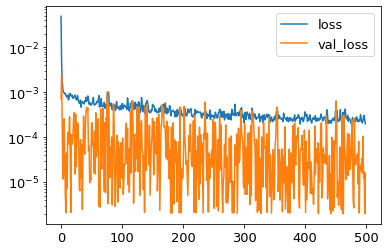

In [131]:
# Keras LSTM model
model = Sequential()

# First layer specifies input_shape and returns sequences
model.add(LSTM(units=100, return_sequences=True, 
               input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
# Dropout layer to prevent overfitting
model.add(Dropout(rate=0.1))

# Last layer doesn't return sequences (middle layers should return sequences)
model.add(LSTM(units=100))
model.add(Dropout(rate=0.1))

# Dense layer to return prediction
model.add(Dense(1))

# Compile model; adam optimizer, mse loss
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

result = model.fit(Xtrain, ytrain, verbose=0, validation_split=0.01,
                   callbacks = [TqdmCallback(verbose=1)],#es
                   batch_size=40,
                   epochs=500)

# Plot loss and save model
epochs = es.stopped_epoch
plt.semilogy(result.history['loss'],label='loss')
plt.semilogy(result.history['val_loss'],label='val_loss')
plt.legend()

model.save('lstm_Temp_100.h5')

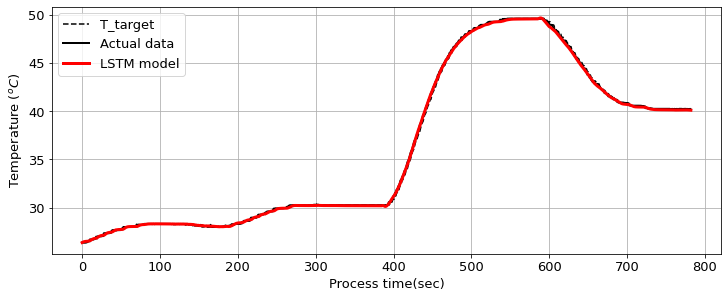

In [135]:
# Predict using LSTM
# Load LSTM model

model50 = load_model('lstm_Temp_50.h5')
yp_s50 = model50.predict(Xtrain)

model100 = load_model('lstm_Temp_100.h5')
yp_s100 = model100.predict(Xtrain)

#model150 = load_model('lstm150.h5')
#yp_s150 = model150.predict(Xtrain)


# Unscale data
Xtest_us = s_x.inverse_transform(Xtrain[:,-1,:])
ytest_us = s_y.inverse_transform(ytrain)

yp50 = s_y.inverse_transform(yp_s50)
yp100 = s_y.inverse_transform(yp_s100)
#yp150 = s_y.inverse_transform(yp_s150)

# Derive Tsp (sp) and T1 (pv) from X data
sp = Xtest_us[:,0]
pv = Xtest_us[:,0] + Xtest_us[:,1]

# Plot SP, PID response, and LSTM response
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(12, 10))
ax=plt.subplot(2,1,1)
ax.grid()
plt.plot(sp,'k--',label=r'T_target')
plt.plot(ytest_us,'k-',linewidth=2,label='Actual data')

#plt.plot(yp50,'g-',linewidth=2,label='LSTM model50')
plt.plot(yp100,'r-',linewidth=3,label='LSTM model')
#plt.plot(yp150,'r-',linewidth=2,label='LSTM model150')
plt.xlabel('Process time(sec)')
plt.ylabel(r'Temperature ($^oC$)')
plt.legend(loc='best')
plt.show()

In [133]:
from numpy import linalg as LA

err = ytest_us - yp

#np.sum(np.power((actual_value-predicted_value),2))

fitness50 = 100*(1-(LA.norm((yp50-ytest_us),ord=2))/(LA.norm((yp50-yp50.mean()),ord=2)))
fitness100 = 100*(1-(LA.norm((yp100-ytest_us),ord=2))/(LA.norm((yp100-yp100.mean()),ord=2)))
#fitness150 = 100*(1-(LA.norm((yp150-ytest_us),ord=2))/(LA.norm((yp150-yp150.mean()),ord=2)))
#fitness50 = 100*(1-(LA.norm((yp50-ytest_us)).sum()/LA.norm((yp50-yp50.mean())).sum()))
#fitness100 = 100*(1-(LA.norm((yp100-ytest_us)).sum()/LA.norm((yp100-yp100.mean())).sum()))

print('LSTM50=',fitness50,'LSTM100=',fitness100)#'LSTM150=',fitness150)

LSTM50= 96.30144179985069 LSTM100= 98.82755886755868


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from tqdm import tqdm # Progress bar

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split 

# For LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from tensorflow.keras.models import load_model

# For TCLab
import tclab

Using TensorFlow backend.


In [3]:
speedup = 10
TCLab = tclab.setup(connected=False, speedup = speedup)

In [4]:
# PID Parameters
Kc   = 10.0
tauI = 170.0 # sec
tauD = 4.0  # sec

#-----------------------------------------
# PID Controller
#-----------------------------------------

def pid(sp,pv,pv_last,ierr,dt):
    # PID coefficients in terms of tuning parameters
    KP = Kc
    KI = Kc / tauI
    KD = Kc * tauD
    
    # ubias for controller (initial heater)
    op0 = 0 
    
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    
    # calculate the error
    error = sp - pv
    
    # calculate the integral error
    ierr = ierr + KI * error * dt
    
    # calculate the measurement derivative
    if dt>=1e-8:
        dpv = (pv - pv_last) / dt
    else:
        dpv = 0.0;
    
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
        
    # return the controller output and PID terms
    return [op,P,I,D]

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


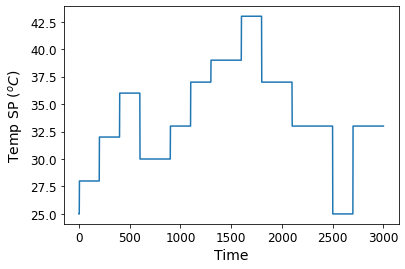

In [30]:
##### Set up run parameters #####

# Run time in minutes
run_time = 70.0

# Number of cycles
loops = int(3001)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
Q1 = np.zeros(loops) # Heater values
tm = np.zeros(loops) # Time

# Temperature set point (degC)
with TCLab() as lab:
    Tsp1 = np.ones(loops) * lab.T1

# vary temperature setpoint
# Heater set point steps
Tsp1[0:3] = 25.0
Tsp1[3:200] = 28.0
Tsp1[200:400] = 32.0
Tsp1[400:600] = 36.0
Tsp1[600:900] = 30.0
Tsp1[900:1100] = 33.0
Tsp1[1100:1300] = 37.0
Tsp1[1300:1600] = 39.0
Tsp1[1600:1800] = 43.0
Tsp1[1800:2100] = 37.0
Tsp1[2100:2500] = 33.0
Tsp1[2500:2700] = 25.0
Tsp1[2700:3001] = 33.0

#Tsp1[0:3] = 27.0
#Tsp1[3:200] = 41.0
#Tsp1[200:400] = 51.0
#Tsp1[400:600] = 40.0
#Tsp1[600:900] = 30.0
#Tsp1[900:1100] = 45.0
#Tsp1[1100:1300] = 55.0
#Tsp1[1300:1600] = 30.0
#Tsp1[1600:1800] = 40.0
#Tsp1[1800:2100] = 55.0
#Tsp1[2100:2500] = 35.0
#Tsp1[2500:2700] = 29.0
#Tsp1[2700:3001] = 45.0


#end = 30 # leave 1st 30 seconds of temp set point as room temp
#while end <= loops:
#    start = end
#    # keep new temp set point value for anywhere from 4 to 10 min
#    end += random.randint(240,600) 
#    Tsp1[start:end] = random.randint(30,70)

# Plot
plt.plot(Tsp1)
plt.xlabel('Time',size=14)
plt.ylabel(r'Temp SP ($^oC$)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.savefig('SP_profile.png');

In [31]:
# Data collection

with TCLab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    #print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Integral error
    ierr = 0.0
    # Integral absolute error
    iae = 0.0
    
    prev_time = 0
    for i,t in enumerate(tclab.clock(loops-1)):
        tm[i] = t
        dt = t - prev_time
        
        # Read temperatures in Kelvin 
        T1[i] = lab.T1

        # Integral absolute error
        iae += np.abs(Tsp1[i]-T1[i])

        # Calculate PID output
        [Q1[i],P,ierr,D] = pid(Tsp1[i],T1[i],T1[i-1],ierr,dt)
        
        # Calculate MPC output

        # Write heater output (0-100)
        lab.Q1(Q1[i])

        # Print line of data
        if i%100==0:
            print(('{:6.1f} {:6.2f} {:6.2f} ' + \
                  '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                      tm[i],Tsp1[i],T1[i], \
                      Q1[i],P,ierr,D,iae))
        
        prev_time = t

TCLab version 0.4.9
Simulated TCLab
Temperature 1: 20.95 °C
   0.0  25.00  20.95  40.51  40.51   0.00  -0.00   4.05
 100.1  28.00  28.36   8.28  -3.62  11.91  -0.00 226.16
 200.1  32.00  28.04  51.45  39.60  11.85  -0.00 237.96
 300.1  32.00  32.23  16.21  -2.30  18.51  -0.00 365.56
 400.1  36.00  32.23  43.70  37.70  18.76 -12.76 382.18
 500.1  36.00  36.10  24.36  -0.98  25.33  -0.00 503.08
 600.1  30.00  35.78   0.00 -57.75  25.16  12.64 521.19
 700.1  30.00  30.62  15.18  -6.18  21.36  -0.00 819.93
 800.1  30.00  30.30  16.08  -2.96  19.05  -0.00 859.86
 900.1  33.00  29.97  61.25  30.26  17.56  13.43 893.56
1000.1  33.00  33.20  19.67  -1.97  21.64  -0.00 978.97
1100.1  37.00  32.87  75.22  41.25  21.07  12.89 1001.55
1200.1  37.00  37.06  39.50  -0.64  27.38  12.76 1124.99
1300.1  39.00  37.06  46.44  19.36  27.08  -0.00 1134.99
1400.1  39.00  39.32  13.69  -3.21  30.47 -13.57 1196.37
1500.0  39.00  39.00  30.40   0.02  30.38  -0.00 1198.14
1600.1  43.00  39.00  70.63  40.02  30.

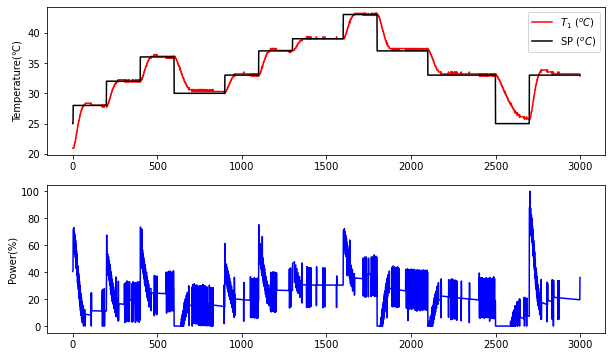

In [32]:
# Save csv file
df = pd.DataFrame()
df['Q1'] = Q1[:i]
df['Q1'].fillna(0,inplace=True)
df['T1'] = T1[:i]
df['Tsp'] = Tsp1[:i]
df.to_csv('PID_train_data.csv',index=False)

# Plot
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(df['T1'],'r-',label='$T_1$ $(^oC)$')
plt.plot(df['Tsp'],'k-',label='SP $(^oC)$')
plt.ylabel('Temperature(℃)')
plt.legend()
plt.savefig('PID_train.png');

plt.subplot(2,1,2)
plt.plot(df['Q1'],'b-',label='$Q_1$ (%)')
plt.ylabel('Power(%)')
plt.show()


In [13]:
df = pd.read_csv('PID_train_data.csv')
print(df)

             Q1       T1   Tsp
0     40.505000  20.9495  25.0
1     40.745647  20.9495  25.0
2     40.983912  20.9495  25.0
3     71.402795  20.9495  28.0
4     71.825825  20.9495  28.0
...         ...      ...   ...
2995  33.865430  33.5192  33.0
2996  21.195367  33.5192  33.0
2997  21.166353  33.5192  33.0
2998  21.137034  33.5192  33.0
2999  21.104660  33.5192  33.0

[3000 rows x 3 columns]


In [14]:
df.shape[0]

3000

In [15]:
df = pd.read_csv('PID_train_data.csv')
# Create new feature: setpoint error & T0

ds =df.shape[0] 

df['T0'] = df['T1']
df['T0'][0] = df['T1'][0]
df['T0'][1:ds] = df['T1'][0:ds-1]

df['err'] = df['Tsp'] - df['T1']
#print(df['T0'],df['T1'])
# Load possible features

X = df[['T1','err']].values
y = df[['Q1']].values


# Scale data
s_x = MinMaxScaler()
Xs = s_x.fit_transform(X)

#pickle.dump(Xs, open('scaler.pkl','wb'))

s_y = MinMaxScaler()
ys = s_y.fit_transform(y)

# Each input uses last 'window' number of Tsp and err to predict the next Q1
window = 15
X_lstm = []
y_lstm = []
for i in range(window,len(df)):
    X_lstm.append(Xs[i-window:i])
    y_lstm.append(ys[i])

# Reshape data to format accepted by LSTM
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split into train and test 
Xtrain, Xtest, ytrain, ytest = train_test_split(X_lstm,y_lstm,test_size=0.01,shuffle=False)

In [4]:
# Keras LSTM model
model = Sequential()

# First layer specifies input_shape and returns sequences
model.add(LSTM(units=150, return_sequences=True, 
               input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
# Dropout layer to prevent overfitting
model.add(Dropout(rate=0.1))

# Last layer doesn't return sequences (middle layers should return sequences)
model.add(LSTM(units=150))
model.add(Dropout(rate=0.1))

# Dense layer to return prediction
model.add(Dense(1))

# Compile model; adam optimizer, mse loss
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

result = model.fit(Xtrain, ytrain, verbose=0, validation_split=0.4,
                   callbacks = [TqdmCallback(verbose=1)],#es
                   batch_size=50,
                   epochs=300)

# Plot loss and save model
epochs = es.stopped_epoch
plt.semilogy(result.history['loss'],label='loss')
plt.semilogy(result.history['val_loss'],label='val_loss')
plt.legend()

model.save('lstm_model_high.h5')

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

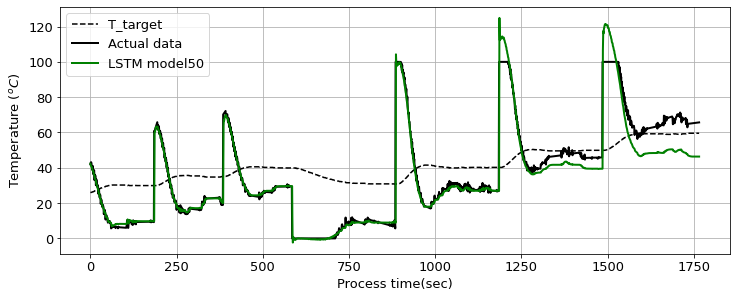

In [35]:

model50 = load_model('lstm_model_low2.h5')
yp_s50 = model50.predict(Xtrain)


# Unscale data
Xtest_us = s_x.inverse_transform(Xtrain[:,-1,:])
ytest_us = s_y.inverse_transform(ytrain)

yp50 = s_y.inverse_transform(yp_s50)


# Derive Tsp (sp) and T1 (pv) from X data
sp = Xtest_us[:,0]
pv = Xtest_us[:,0] + Xtest_us[:,1]

# Plot SP, PID response, and LSTM response
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(12, 10))
ax=plt.subplot(2,1,1)
ax.grid()
plt.plot(sp,'k--',label=r'T_target')
plt.plot(ytest_us,'k-',linewidth=2,label='Actual data')

plt.plot(yp50,'g-',linewidth=2,label='LSTM model50')

plt.xlabel('Process time(sec)')
plt.ylabel(r'Temperature ($^oC$)')
plt.legend(loc='best')
plt.show()

In [19]:
# Predict using LSTM
# Load LSTM model



model50 = load_model('lstm50.h5')
yp_s50 = model50.predict(Xtrain)

model100 = load_model('lstm100.h5')
yp_s100 = model100.predict(Xtrain)

model150 = load_model('lstm150.h5')
yp_s150 = model150.predict(Xtrain)


# Unscale data
Xtest_us = s_x.inverse_transform(Xtrain[:,-1,:])
ytest_us = s_y.inverse_transform(ytrain)

yp50 = s_y.inverse_transform(yp_s50)
yp100 = s_y.inverse_transform(yp_s100)
yp150 = s_y.inverse_transform(yp_s150)

# Derive Tsp (sp) and T1 (pv) from X data
sp = Xtest_us[:,0]
pv = Xtest_us[:,0] + Xtest_us[:,1]

# Plot SP, PID response, and LSTM response
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(12, 10))
ax=plt.subplot(2,1,1)
ax.grid()
plt.plot(sp,'k--',label=r'T_target')
plt.plot(ytest_us,'k-',linewidth=2,label='Actual data')

plt.plot(yp50,'g-',linewidth=2,label='LSTM model50')
plt.plot(yp100,'b-',linewidth=2,label='LSTM model100')
plt.plot(yp150,'r-',linewidth=2,label='LSTM model150')
plt.xlabel('Process time(sec)')
plt.ylabel(r'Temperature ($^oC$)')
plt.legend(loc='best')
plt.show()

ValueError: in user code:

    C:\Users\gigan\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\gigan\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\gigan\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\gigan\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\gigan\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\gigan\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\gigan\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\gigan\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\gigan\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer sequential_9: expected shape=(None, None, 3), found shape=(None, 15, 2)


In [73]:
from numpy import linalg as LA

err = ytest_us - yp

#np.sum(np.power((actual_value-predicted_value),2))

fitness50 = 100*(1-(LA.norm((yp50-ytest_us),ord=2))/(LA.norm((yp50-yp50.mean()),ord=2)))
fitness100 = 100*(1-(LA.norm((yp100-ytest_us),ord=2))/(LA.norm((yp100-yp100.mean()),ord=2)))
fitness150 = 100*(1-(LA.norm((yp150-ytest_us),ord=2))/(LA.norm((yp150-yp150.mean()),ord=2)))
#fitness50 = 100*(1-(LA.norm((yp50-ytest_us)).sum()/LA.norm((yp50-yp50.mean())).sum()))
#fitness100 = 100*(1-(LA.norm((yp100-ytest_us)).sum()/LA.norm((yp100-yp100.mean())).sum()))

print('LSTM50=',fitness50,'LSTM100=',fitness100,'LSTM150=',fitness150)

LSTM50= 92.65060008815746 LSTM100= 94.60481472832771 LSTM150= 97.19677476007563


In [23]:
abs((yp-ytest_us)).sum()

506.3183460723877

In [24]:
abs((yp-yp.mean())).sum()

5488.407